In [ ]:
!pip install pytorch-crf

In [ ]:
import math
import os
import json
import re
import random

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from collections import defaultdict

from torchcrf import CRF

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Datasets/Coleridge/datasets/train.csv')
train_items = train.sample(n=1000, random_state=42)

X_train, X_test = train_test_split(train_items, test_size=0.1, random_state=42)
train_papers = {}
test_papers = {}

for i in range(len(X_train)):
    curr_path = os.path.join(
        os.getcwd(),
        'drive',
        'My Drive',
        'Datasets',
        'Coleridge',
        'datasets',
        'train',
        X_train.iloc[i]['Id'] + '.json')
    with open(curr_path, 'r') as file:
        curr_json = json.load(file)
        train_papers[X_train.iloc[i]['Id']] = curr_json

for i in range(len(X_test)):
    curr_path = os.path.join(
        os.getcwd(),
        'drive',
        'My Drive',
        'Datasets',
        'Coleridge',
        'datasets',
        'train',
        X_test.iloc[i]['Id'] + '.json')
    with open(curr_path, 'r') as file:
        curr_json = json.load(file)
        test_papers[X_test.iloc[i]['Id']] = curr_json

In [ ]:
# Hyperparameters
MAX_LENGTH = 64 # max no. words for each sentence.
OVERLAP = 20 # if a sentence exceeds MAX_LENGTH, we split it to multiple sentences with overlapping

MAX_SAMPLE = None # set a small number for experimentation, set None for production.


def clean_training_text(txt):
    """
    similar to the default clean_text function but without lowercasing.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt)).strip()

def shorten_sentences(sentences):
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences

def find_sublist(big_list, small_list):
    all_positions = []
    for i in range(len(big_list) - len(small_list) + 1):
        if small_list == big_list[i:i+len(small_list)]:
            all_positions.append(i)

    return all_positions

def tag_sentence(sentence, labels): # requirement: both sentence and labels are already cleaned
    sentence_words = sentence.split()

    if labels is not None and any(re.findall(f'\\b{label}\\b', sentence)
                                  for label in labels): # positive sample
        nes = ['O'] * len(sentence_words)
        for label in labels:
            label_words = label.split()

            all_pos = find_sublist(sentence_words, label_words)
            for pos in all_pos:
                nes[pos] = 'B'
                for i in range(pos+1, pos+len(label_words)):
                    nes[i] = 'I'

        return True, list(zip(sentence_words, nes))

    else: # negative sample
        nes = ['O'] * len(sentence_words)
        return False, list(zip(sentence_words, nes))

In [ ]:
import re
from tqdm import tqdm
import random

cnt_pos, cnt_neg = 0, 0 # number of sentences that contain/not contain labels
ner_data = []

pbar = tqdm(total=len(train_items))
for i, id, dataset_label in X_train[['Id', 'dataset_label']].itertuples():
    # paper
    paper = train_papers[id]

    # labels
    labels = dataset_label.split('|')
    labels = [clean_training_text(label) for label in labels]

    # sentences
    sentences = set([clean_training_text(sentence) for section in paper
                 for sentence in section['text'].split('.')
                ])
    sentences = shorten_sentences(sentences) # make sentences short
    sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars

    # positive sample
    for sentence in sentences:
        is_positive, tags = tag_sentence(sentence, labels)
        if is_positive:
            cnt_pos += 1
            ner_data.append(tags)
        elif any(word in sentence.lower() for word in ['data', 'study']):
            ner_data.append(tags)
            cnt_neg += 1

    # process bar
    pbar.update(1)
    pbar.set_description(f"Training data size: {cnt_pos} positives + {cnt_neg} negatives")

# shuffling
random.shuffle(ner_data)

Training data size: 2523 positives + 38331 negatives:  90%|█████████ | 900/1000 [00:15<00:01, 68.25it/s]

In [ ]:
print(len(sentences[2]))
print(sentences[2])

158
However the deep learning models employed in AD classification 10 12 only use one layer of CNN which reduces the system capability to learn complex boundaries


In [ ]:
def build_mappings(data):
    word_set = set()
    tag_set = set()

    # Iterate through the dataset to collect all unique words and tags
    for sentence in data:
        for word, tag in sentence:
            word_set.add(word)
            tag_set.add(tag)

    # Create word2idx mapping, starting with special tokens
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, word in enumerate(word_set, start=2):  # Start indexing from 2 to leave 0 and 1 for special tokens
        word2idx[word] = idx

    # Create tag2idx mapping
    tag2idx = {'O': 0}  # Often 'O' is the default label, so start indexing from 0
    for idx, tag in enumerate(tag_set):  # Start from 1 because 0 is reserved for 'O'
        if tag != 'O':  # Ensure 'O' is always mapped to 0
            tag2idx[tag] = idx

    return word2idx, tag2idx


word2idx, tag2idx = build_mappings(ner_data)
print(word2idx)
print(tag2idx)

{'<PAD>': 0, '<UNK>': 1, 'constructive': 2, 'overlay': 3, 'ESSA': 4, 'aggravate': 5, 'configure': 6, 'Arundel': 7, 'estimators': 8, 'Crisp': 9, 'Extension': 10, 'SS': 11, 'Marsh': 12, 'Defined': 13, 'main': 14, 'render': 15, 'parasite': 16, 'P4PAY': 17, '1102': 18, 'meander': 19, 'tax': 20, 'Spreen': 21, 'actors': 22, 'FSL': 23, 'Occasionally': 24, 'below': 25, 'Kato': 26, 'engines': 27, 'patches': 28, 'ncats': 29, 'arative': 30, 'physiology': 31, 'Pangolin': 32, 'weight': 33, 'Brain': 34, 'nigra': 35, 'gratefully': 36, 'Tobias': 37, 'Wentz': 38, 'P4CURMAR': 39, '2019a': 40, 'particles': 41, 'Owens': 42, 'cantly': 43, 'raciallethnic': 44, 'Five': 45, 'illegally': 46, 'tradeoffs': 47, 'ringing': 48, 'rendition': 49, 'trans': 50, 'INSIGHT': 51, 'maxima': 52, 'consulting': 53, 'Ruddock': 54, 'Hb': 55, 'utilization': 56, 'Simard': 57, '8760': 58, 'loci': 59, 'Fay': 60, '68W': 61, 'SF1': 62, 'disappearance': 63, 'Hz': 64, 'stimulation': 65, 'discarded': 66, 'supervisions': 67, 'accomplishme

In [ ]:
positive_samples = [sample for sample in ner_data if any(tag in ['B', 'I'] for _, tag in sample)]
negative_samples = [sample for sample in ner_data if all(tag == 'O' for _, tag in sample)]

In [ ]:
class NERDataset(Dataset):
    def __init__(self, data, word2idx, tag2idx):
        """
        Args:
            data (list of list of tuples): The dataset where each element is a list of (word, tag) tuples.
            word2idx (dict): Mapping from words to indices.
            tag2idx (dict): Mapping from tags to indices.
            max_len (int): Maximum length for padding.
        """
        self.data = data
        self.word2idx = word2idx
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]

        # Separate words and tags from the tuples
        words = [w for w, t in sentence]
        tags = [t for w, t in sentence]

        # Convert words and tags to their corresponding indices
        word_ids = [self.word2idx.get(w, self.word2idx['<UNK>']) for w in words]
        tag_ids = [self.tag2idx.get(t, self.tag2idx['O']) for t in tags]

        # Convert to tensors
        return torch.tensor(word_ids), torch.tensor(tag_ids)

def collate_fn(batch):
    words, tags = zip(*batch)

    words_padded = pad_sequence(words, batch_first=True, padding_value=word2idx['<PAD>'])
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=tag2idx['O'])

    return words_padded, tags_padded

In [ ]:
batch_size = 32
batches = []

# Loop through positive samples and add balanced batches
for i in range(0, len(positive_samples), batch_size // 2):
    pos_batch = positive_samples[i:i + batch_size // 2]
    neg_batch = negative_samples[i:i + batch_size // 2]
    batch = pos_batch + neg_batch
    random.shuffle(batch)
    batches.append(batch)


dataloaders = []
for batch in batches:
    dataset = NERDataset(batch, word2idx, tag2idx)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    dataloaders.append(dataloader)

In [ ]:
class NERLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=128):
        super(NERLSTM, self).__init__()

        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['<PAD>'])

        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        # x: (batch_size, max_len)
        embeds = self.embedding_layer(x)
        # print('embeds: ', embeds)

        lstm_out, _  = self.lstm(embeds)
        # print('lstm out: ', lstm_out)

        tag_scores = self.fc(lstm_out)
        # print('tag scores', tag_scores)

        return tag_scores


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                param.data.fill_(0)

In [ ]:
import torch
import math

embedding_dim = 128
hidden_dim = 32
vocab_size = len(word2idx)
tagset_size = len(tag2idx)
max_len = 50

model = NERLSTM(vocab_size, tagset_size, embedding_dim, hidden_dim)
model.apply(init_weights)
# model = SimpleNERModel(vocab_size, tagset_size, embedding_dim)

class_weights = torch.tensor([1.0, 10.0, 10.0])  # Example weights for 'O', 'B', 'I'
loss_function = nn.CrossEntropyLoss(weight=class_weights, ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

dataset = NERDataset(ner_data, word2idx, tag2idx)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

epochs = 100
for epoch in range(epochs):
    total_loss = 0.0
    for batch in dataloader:
        words, tags = batch

        if torch.all(words == word2idx['<PAD>']):
            print("All words in this batch are padding!")
            continue  # Skip this batch

        if torch.isnan(words).any():
            print("NaN detected in input!")

        optimizer.zero_grad()

        outputs = model(words)

        outputs = outputs.view(-1, tagset_size)
        tags = tags.view(-1)

        loss = loss_function(outputs, tags)

        # Check for NaNs in loss
        if math.isnan(loss.item()):
            # print(words.values(), tags.values())
            print("NaN loss encountered, exiting.")
            break

        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN gradient found in {name}")

        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.step()

        loss_item = loss.item()

        # Check for NaNs in model parameters
        for name, param in model.named_parameters():
            if torch.isnan(param.grad).any():
                print(f"NaN in gradients of {name}")

        total_loss += loss_item

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")


NaN loss encountered, exiting.
Epoch 1/100, Loss: 0.08606743532727022


Training data size: 2523 positives + 38331 negatives:  90%|█████████ | 900/1000 [00:29<00:01, 68.25it/s]

NaN loss encountered, exiting.
Epoch 2/100, Loss: 0.5075170899594147
NaN loss encountered, exiting.
Epoch 3/100, Loss: 0.006939686333442891
NaN loss encountered, exiting.
Epoch 4/100, Loss: 0.07103182377763011
NaN loss encountered, exiting.
Epoch 5/100, Loss: 0.3661306062961035
NaN loss encountered, exiting.
Epoch 6/100, Loss: 0.08615769821340116
NaN loss encountered, exiting.
Epoch 7/100, Loss: 0.015823251764539262
NaN loss encountered, exiting.
Epoch 8/100, Loss: 0.0177017179826429
NaN loss encountered, exiting.
Epoch 9/100, Loss: 0.06312764828940139
NaN loss encountered, exiting.
Epoch 10/100, Loss: 0.36447442911786837
NaN loss encountered, exiting.
Epoch 11/100, Loss: 0.0
NaN loss encountered, exiting.
Epoch 12/100, Loss: 0.0983170037724789
NaN loss encountered, exiting.
Epoch 13/100, Loss: 0.08530355208729727
NaN loss encountered, exiting.
Epoch 14/100, Loss: 0.1604160211269098
NaN loss encountered, exiting.
Epoch 15/100, Loss: 0.1850496877527013
NaN loss encountered, exiting.
Epo

In [ ]:
cnt_pos_test, cnt_neg_test = 0, 0  # number of sentences that contain/not contain labels
ner_data_test = []

pbar = tqdm(total=len(X_test))
for i, id, dataset_label in X_test[['Id', 'dataset_label']].itertuples():
    # paper
    paper = test_papers[id]

    # labels
    labels = dataset_label.split('|')
    labels = [clean_training_text(label) for label in labels]

    # sentences
    sentences = set([clean_training_text(sentence) for section in paper
                 for sentence in section['text'].split('.')
                ])
    sentences = shorten_sentences(sentences)  # make sentences short
    sentences = [sentence for sentence in sentences if len(sentence) > 10]  # only accept sentences with length > 10 chars

    # positive sample
    for sentence in sentences:
        is_positive, tags = tag_sentence(sentence, labels)
        if is_positive:
            cnt_pos_test += 1
            ner_data_test.append(tags)
        elif any(word in sentence.lower() for word in ['data', 'study']):
            ner_data_test.append(tags)
            cnt_neg_test += 1

    # process bar
    pbar.update(1)
    pbar.set_description(f"Test data size: {cnt_pos_test} positives + {cnt_neg_test} negatives")

# Shuffle the test data
random.shuffle(ner_data_test)


Test data size: 1 positives + 37 negatives:   2%|▏         | 2/100 [00:00<00:01, 80.69it/s]
Training data size: 2523 positives + 38331 negatives:  90%|█████████ | 900/1000 [12:32<01:23,  1.20it/s]

Test data size: 256 positives + 4476 negatives: 100%|██████████| 100/100 [00:02<00:00, 34.55it/s]

In [ ]:
# Create the test dataset and dataloader
test_dataset = NERDataset(ner_data_test, word2idx, tag2idx)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
from sklearn.metrics import classification_report

# Assuming test set is loaded similarly as the training set
model.eval()
true_tags, pred_tags = [], []
with torch.no_grad():
    for batch in test_dataloader:
        words, tags = batch
        outputs = model(words)
        predictions = torch.argmax(outputs, dim=2)  # (batch_size, max_len)

        true_tags.extend(tags.view(-1).tolist())
        pred_tags.extend(predictions.view(-1).tolist())

# Filter out padding tokens and calculate metrics
true_tags = [tag for tag in true_tags if tag != word2idx['<PAD>']]
pred_tags = [tag for tag in pred_tags if tag != word2idx['<PAD>']]


In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, word2idx, tag2idx):
    model.eval()  # Set the model to evaluation mode
    all_true_tags = []
    all_pred_tags = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in dataloader:
            words, true_tags = batch

            # Get the model predictions
            outputs = model(words)
            predictions = torch.argmax(outputs, dim=-1)  # Get the tag with the highest score

            # Convert the predictions and true tags to lists
            true_tags = true_tags.view(-1).cpu().numpy()
            predictions = predictions.view(-1).cpu().numpy()

            # Mask out padding tokens (ignore_index for the '<PAD>' token)
            mask = (words.view(-1) != word2idx['<PAD>']).cpu().numpy()

            true_tags = true_tags[mask]
            predictions = predictions[mask]

            # Collect all true and predicted tags
            all_true_tags.extend(true_tags)
            all_pred_tags.extend(predictions)

    # Print classification report
    report = classification_report(all_true_tags, all_pred_tags, target_names=[key for key in tag2idx.keys()])
    print(report)
    return report


evaluate_model(model, test_dataloader, word2idx, tag2idx)

              precision    recall  f1-score   support

           O       1.00      0.29      0.45    130938
           I       0.00      0.46      0.01       427
           B       0.00      0.66      0.01       271

    accuracy                           0.29    131636
   macro avg       0.34      0.47      0.15    131636
weighted avg       0.99      0.29      0.45    131636



'              precision    recall  f1-score   support\n\n           O       1.00      0.29      0.45    130938\n           I       0.00      0.46      0.01       427\n           B       0.00      0.66      0.01       271\n\n    accuracy                           0.29    131636\n   macro avg       0.34      0.47      0.15    131636\nweighted avg       0.99      0.29      0.45    131636\n'

# CRFModel

In [ ]:
# Custom collate function for padding sequences
def collate_fn(batch):
    # Separate words and tags from the batch
    words, tags = zip(*batch)

    # Pad sequences of words and tags
    padded_words = pad_sequence(words, batch_first=True, padding_value=word2idx['<PAD>'])
    padded_tags = pad_sequence(tags, batch_first=True, padding_value=tag2idx['O'])  # 'O' is typically the padding tag

    return padded_words, padded_tags

In [ ]:
def collate_fn(batch):
    # Separate words and tags from the batch
    words, tags = zip(*batch)

    # Pad sequences of words and tags
    padded_words = pad_sequence(words, batch_first=True, padding_value=word2idx['<PAD>'])
    padded_tags = pad_sequence(tags, batch_first=True, padding_value=tag2idx['O'])  # 'O' is typically the padding tag

    return padded_words, padded_tags


# Sample Dataset class to return features (embeddings) and labels
class CRFDataset(Dataset):
    def __init__(self, data, word2idx, tag2idx, max_len=50):
        self.data = data
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]

        # Extract words and tags
        words = [w for w, t in sentence]
        tags = [t for w, t in sentence]

        # Convert words and tags to their corresponding indices
        word_ids = [self.word2idx.get(w, self.word2idx['<UNK>']) for w in words]
        tag_ids = [self.tag2idx.get(t, self.tag2idx['O']) for t in tags]

        # Pad sequences to the max length
        word_ids = word_ids + [self.word2idx['<PAD>']] * (self.max_len - len(word_ids))
        tag_ids = tag_ids + [self.tag2idx['O']] * (self.max_len - len(tag_ids))

        return torch.tensor(word_ids), torch.tensor(tag_ids)


train_dataset = CRFDataset(ner_data, word2idx, tag2idx, max_len=50)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataset = CRFDataset(ner_data_test, word2idx, tag2idx, max_len=50)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
class CRFModel(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128):
        super(CRFModel, self).__init__()
        # Word embedding layer
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['<PAD>'])

        # Fully connected layer to project embeddings to tag space
        self.fc = nn.Linear(embedding_dim, tagset_size)

        # CRF layer
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, x):
        embeds = self.embedding_layer(x)  # Convert tokens to embeddings
        emissions = self.fc(embeds)       # Project embeddings to tag scores
        return emissions  # Return emissions for each token in the sequence

    def loss(self, emissions, tags, mask):
        return -self.crf(emissions, tags, mask=mask)  # Maximize log-likelihood

    def predict(self, emissions, mask):
        return self.crf.decode(emissions, mask=mask)


In [ ]:
# Custom function to generate a mask for valid tokens
def generate_mask(words, word2idx):
    return (words != word2idx['<PAD>']).bool()

# Training loop for the standalone CRF model
def train_crf(model, dataloader, optimizer, word2idx, tag2idx, epochs=10):
    for epoch in range(epochs):
        total_loss = 0.0
        model.train()

        for batch in dataloader:
            words, tags = batch
            mask = generate_mask(words, word2idx)

            # Forward pass
            emissions = model(words)

            # Compute loss
            loss = model.loss(emissions, tags, mask)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")

# Example of how to instantiate the model and optimizer
model = CRFModel(vocab_size=len(word2idx), tagset_size=len(tag2idx))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the CRF model
train_crf(model, train_dataloader, optimizer, word2idx, tag2idx, epochs=100)


Epoch 1/100, Loss: 132.4694657523649
Epoch 2/100, Loss: 16.765132142308175
Epoch 3/100, Loss: 9.301167711767258
Epoch 4/100, Loss: 6.28997106727624
Epoch 5/100, Loss: 4.6933346772996725
Epoch 6/100, Loss: 3.7943500212233983
Epoch 7/100, Loss: 3.2365981951857696
Epoch 8/100, Loss: 2.927649723521974
Epoch 9/100, Loss: 2.704898098995654
Epoch 10/100, Loss: 2.593668262381617
Epoch 11/100, Loss: 2.5086480824389117
Epoch 12/100, Loss: 2.4446358312921963
Epoch 13/100, Loss: 2.4001481772029223
Epoch 14/100, Loss: 2.3684547798840816
Epoch 15/100, Loss: 2.3408965321378776
Epoch 16/100, Loss: 2.3119159650317185
Epoch 17/100, Loss: 2.3229261954127574
Epoch 18/100, Loss: 2.2952097738358597
Epoch 19/100, Loss: 2.282253530637865
Epoch 20/100, Loss: 2.263862287942189
Epoch 21/100, Loss: 2.273218409008782
Epoch 22/100, Loss: 2.2579630714379535
Epoch 23/100, Loss: 2.2701109763506153
Epoch 24/100, Loss: 2.2412038765900193
Epoch 25/100, Loss: 2.2701977567926646
Epoch 26/100, Loss: 2.280262823672433
Epoch 

In [ ]:
from sklearn.metrics import classification_report

def evaluate_crf(model, dataloader, word2idx, tag2idx):
    model.eval()  # Set the model to evaluation mode
    all_true_tags = []
    all_pred_tags = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in dataloader:
            words, true_tags = batch

            mask = generate_mask(words, word2idx)
            emissions = model(words)
            predictions = model.predict(emissions, mask)

            # Flatten the predictions and true tags
            for i in range(len(predictions)):
                true = true_tags[i][mask[i] == 1].cpu().numpy()
                pred = predictions[i]
                all_true_tags.extend(true)
                all_pred_tags.extend(pred)

    # Get the unique classes present in both true and predicted labels
    unique_labels = sorted(set(all_true_tags) | set(all_pred_tags))

    # Map tag indices to their names
    label_names = [list(tag2idx.keys())[list(tag2idx.values()).index(label)] for label in unique_labels]

    # Print classification report
    report = classification_report(all_true_tags, all_pred_tags, labels=unique_labels, target_names=label_names)
    print(report)
    return report


# Evaluate the standalone CRF model on the test set
evaluate_crf(model, test_dataloader, word2idx, tag2idx)


              precision    recall  f1-score   support

           O       1.00      1.00      1.00    130938
           I       0.57      0.67      0.62       427
           B       0.63      0.77      0.70       271

    accuracy                           1.00    131636
   macro avg       0.73      0.82      0.77    131636
weighted avg       1.00      1.00      1.00    131636



'              precision    recall  f1-score   support\n\n           O       1.00      1.00      1.00    130938\n           I       0.57      0.67      0.62       427\n           B       0.63      0.77      0.70       271\n\n    accuracy                           1.00    131636\n   macro avg       0.73      0.82      0.77    131636\nweighted avg       1.00      1.00      1.00    131636\n'

# Custom LSTM Cell

In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLinear, self).__init__()

        self.W = nn.Parameter(torch.randn(output_dim, input_dim))
        self.b = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):
        return torch.matmul(x, self.W.T) + self.b


class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomLSTMCell, self).__init__()

        self.hidden_dim = hidden_dim

        self.W_f = CustomLinear(input_dim + hidden_dim, hidden_dim)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))

        self.W_i = CustomLinear(input_dim + hidden_dim, hidden_dim)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_C = CustomLinear(input_dim + hidden_dim, hidden_dim)
        self.b_C = nn.Parameter(torch.zeros(hidden_dim))

        self.W_o = CustomLinear(input_dim + hidden_dim, hidden_dim)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x, h_prev, C_prev):
        combined = torch.cat((x, h_prev), dim=1) # Concatenate input and prev hidden state

        f_t = torch.sigmoid(self.W_f(combined) + self.b_f) # Forget gate

        i_t = torch.sigmoid(self.W_i(combined) + self.b_f) # Input gate

        C_tilde = torch.tanh(self.W_C(combined) + self.b_C) # Candidate cell state

        C_t = f_t * C_prev + i_t * C_tilde # Cell state update

        o_t = torch.sigmoid(self.W_o(combined) + self.b_o) # Output gate

        h_t = o_t * torch.tanh(C_t) # Hidden state update

        return h_t, C_t


class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_cell = CustomLSTMCell(input_dim, hidden_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h_t = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        C_t = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        outputs = []
        for t in range(seq_len):
            h_t, C_t = self.lstm_cell(x[:, t, :], h_t, C_t)
            outputs.append(h_t.unsqueeze(1))

        return torch.cat(outputs, dim=1)

In [ ]:
class CustomNERLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=128):
        super(CustomNERLSTM, self).__init__()

        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['<PAD>'])

        self.lstm = CustomLSTM(embedding_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        embeds = self.embedding_layer(x)

        lstm_out = self.lstm(embeds)

        tag_scores = self.fc(lstm_out)

        return tag_scores

In [ ]:
import torch
import math

embedding_dim = 128
hidden_dim = 32
vocab_size = len(word2idx)
tagset_size = len(tag2idx)
max_len = 50

model = CustomNERLSTM(vocab_size, tagset_size, embedding_dim, hidden_dim)
model.apply(init_weights)
# model = SimpleNERModel(vocab_size, tagset_size, embedding_dim)

class_weights = torch.tensor([1.0, 10.0, 10.0])  # Example weights for 'O', 'B', 'I'
loss_function = nn.CrossEntropyLoss(weight=class_weights, ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

dataset = NERDataset(ner_data, word2idx, tag2idx)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

epochs = 100
for epoch in range(epochs):
    total_loss = 0.0
    for batch in dataloader:
        words, tags = batch

        if torch.all(words == word2idx['<PAD>']):
            print("All words in this batch are padding!")
            continue  # Skip this batch

        if torch.isnan(words).any():
            print("NaN detected in input!")

        optimizer.zero_grad()

        outputs = model(words)

        outputs = outputs.view(-1, tagset_size)
        tags = tags.view(-1)

        loss = loss_function(outputs, tags)

        # Check for NaNs in loss
        if math.isnan(loss.item()):
            # print(words.values(), tags.values())
            print("NaN loss encountered, exiting.")
            break

        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN gradient found in {name}")

        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.step()

        loss_item = loss.item()

        # Check for NaNs in model parameters
        for name, param in model.named_parameters():
            if param.grad is None:
                continue
            if torch.isnan(param.grad).any():
                print(f"NaN in gradients of {name}")

        total_loss += loss_item

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")


NaN loss encountered, exiting.
Epoch 1/100, Loss: 0.028779530935630737
NaN loss encountered, exiting.
Epoch 2/100, Loss: 0.22859207700489087
NaN loss encountered, exiting.
Epoch 3/100, Loss: 0.15245160404505304
NaN loss encountered, exiting.
Epoch 4/100, Loss: 0.06661443116146261
NaN loss encountered, exiting.
Epoch 5/100, Loss: 0.13182731982501272
NaN loss encountered, exiting.
Epoch 6/100, Loss: 0.12932740830479653
NaN loss encountered, exiting.
Epoch 7/100, Loss: 0.03296634699443883
NaN loss encountered, exiting.
Epoch 8/100, Loss: 0.36771024929152596
NaN loss encountered, exiting.
Epoch 9/100, Loss: 0.08020139048356965
NaN loss encountered, exiting.
Epoch 10/100, Loss: 0.021793323176940656
NaN loss encountered, exiting.
Epoch 11/100, Loss: 0.05796038498154642
NaN loss encountered, exiting.
Epoch 12/100, Loss: 0.2043201766663314
NaN loss encountered, exiting.
Epoch 13/100, Loss: 0.02257475345533965
NaN loss encountered, exiting.
Epoch 14/100, Loss: 0.039318755572204114
NaN loss enco

In [ ]:
cnt_pos_test, cnt_neg_test = 0, 0  # number of sentences that contain/not contain labels
ner_data_test = []

pbar = tqdm(total=len(X_test))
for i, id, dataset_label in X_test[['Id', 'dataset_label']].itertuples():
    # paper
    paper = test_papers[id]

    # labels
    labels = dataset_label.split('|')
    labels = [clean_training_text(label) for label in labels]

    # sentences
    sentences = set([clean_training_text(sentence) for section in paper
                 for sentence in section['text'].split('.')
                ])
    sentences = shorten_sentences(sentences)  # make sentences short
    sentences = [sentence for sentence in sentences if len(sentence) > 10]  # only accept sentences with length > 10 chars

    # positive sample
    for sentence in sentences:
        is_positive, tags = tag_sentence(sentence, labels)
        if is_positive:
            cnt_pos_test += 1
            ner_data_test.append(tags)
        elif any(word in sentence.lower() for word in ['data', 'study']):
            ner_data_test.append(tags)
            cnt_neg_test += 1

    # process bar
    pbar.update(1)
    pbar.set_description(f"Test data size: {cnt_pos_test} positives + {cnt_neg_test} negatives")

# Shuffle the test data
random.shuffle(ner_data_test)

Test data size: 256 positives + 4476 negatives: 100%|██████████| 100/100 [00:01<00:00, 63.77it/s]

In [ ]:
# Create the test dataset and dataloader
test_dataset = NERDataset(ner_data_test, word2idx, tag2idx)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
from sklearn.metrics import classification_report

# Assuming test set is loaded similarly as the training set
model.eval()
true_tags, pred_tags = [], []
with torch.no_grad():
    for batch in test_dataloader:
        words, tags = batch
        outputs = model(words)
        predictions = torch.argmax(outputs, dim=2)  # (batch_size, max_len)

        true_tags.extend(tags.view(-1).tolist())
        pred_tags.extend(predictions.view(-1).tolist())

# Filter out padding tokens and calculate metrics
true_tags = [tag for tag in true_tags if tag != word2idx['<PAD>']]
pred_tags = [tag for tag in pred_tags if tag != word2idx['<PAD>']]


Test data size: 256 positives + 4476 negatives: 100%|██████████| 100/100 [00:12<00:00, 63.77it/s]

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, word2idx, tag2idx):
    model.eval()  # Set the model to evaluation mode
    all_true_tags = []
    all_pred_tags = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in dataloader:
            words, true_tags = batch

            # Get the model predictions
            outputs = model(words)
            predictions = torch.argmax(outputs, dim=-1)  # Get the tag with the highest score

            # Convert the predictions and true tags to lists
            true_tags = true_tags.view(-1).cpu().numpy()
            predictions = predictions.view(-1).cpu().numpy()

            # Mask out padding tokens (ignore_index for the '<PAD>' token)
            mask = (words.view(-1) != word2idx['<PAD>']).cpu().numpy()

            true_tags = true_tags[mask]
            predictions = predictions[mask]

            # Collect all true and predicted tags
            all_true_tags.extend(true_tags)
            all_pred_tags.extend(predictions)

    # Print classification report
    report = classification_report(all_true_tags, all_pred_tags, target_names=[key for key in tag2idx.keys()])
    print(report)
    return report

evaluate_model(model, test_dataloader, word2idx, tag2idx)

              precision    recall  f1-score   support

           O       1.00      0.86      0.93    130938
           I       0.02      0.83      0.04       427
           B       0.25      0.69      0.37       271

    accuracy                           0.86    131636
   macro avg       0.42      0.80      0.45    131636
weighted avg       0.99      0.86      0.92    131636



'              precision    recall  f1-score   support\n\n           O       1.00      0.86      0.93    130938\n           I       0.02      0.83      0.04       427\n           B       0.25      0.69      0.37       271\n\n    accuracy                           0.86    131636\n   macro avg       0.42      0.80      0.45    131636\nweighted avg       0.99      0.86      0.92    131636\n'

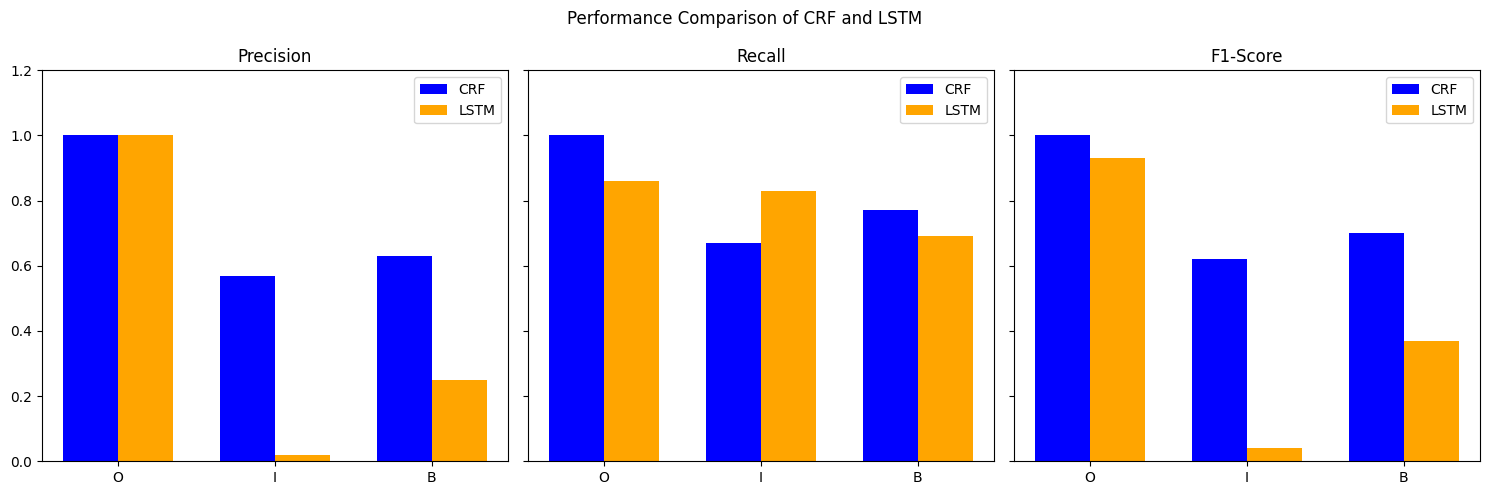

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the algorithms (from your results)
metrics = ['Precision', 'Recall', 'F1-Score']
classes = ['O', 'I', 'B']

# CRF performance
crf_scores = {
    'O': [1.00, 1.00, 1.00],
    'I': [0.57, 0.67, 0.62],
    'B': [0.63, 0.77, 0.70]
}

# LSTM performance
lstm_scores = {
    'O': [1.00, 0.86, 0.93],
    'I': [0.02, 0.83, 0.04],
    'B': [0.25, 0.69, 0.37]
}

# Create a figure for bar plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Performance Comparison of CRF and LSTM')

# Generate bar plots for precision, recall, and F1-scores for each class
for i, metric in enumerate(metrics):
    crf_values = [crf_scores[class_label][i] for class_label in classes]
    lstm_values = [lstm_scores[class_label][i] for class_label in classes]

    bar_width = 0.35
    x = np.arange(len(classes))

    # Bar chart for each metric
    axes[i].bar(x - bar_width/2, crf_values, bar_width, label='CRF', color='blue')
    axes[i].bar(x + bar_width/2, lstm_values, bar_width, label='LSTM', color='orange')

    axes[i].set_title(metric)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(classes)
    axes[i].set_ylim(0, 1.2)
    axes[i].legend()

plt.tight_layout()
plt.show()
